In [6]:
import pandas as pd
from connections import AWS

$\textbf{Appendix: EVT Study}$

Includes the following:
- __Figure 1__: Bar plot of scaling errors
- __Figure 2__: Bar plot of IK errors at peak EVT time
- __Figure 3__: Spaghetti plot of elbow flexion
- __Figure 4__: Representative elbow varus torque plots (done in `biomech/joint_reaction_analysis/jra_subject_plots.ipynb`)
- __Table 7__: Elbow varus torque summary by pitch type; percentage of pitches thrown by pitch type
- __Table 8__: Pitch velocity summary by pitch type

In [7]:
# initialize AWS connection
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{Data Loading}$

In [ ]:
from services.loading import load_mot_file

In [ ]:
# load scaling errors
scaling_errors = aws_connection.load_s3_object('biomechanics/subjects/summary/scaling_errors.csv')

""" IK Errors"""
all_objects = aws_connection.list_s3_objects(prefix='biomechanics/subjects/')
ik_error_objects = [obj for obj in all_objects if 'ik_errors' in obj]

# load peak EVT times for reference
ik_peak_evt = aws_connection.load_s3_object('biomechanics/ml/modeling_datasets/final_ik_peak_evt.csv')

In [ ]:
# iterate through each object
ik_errors = []
outlier_trials = []
for obj in ik_error_objects:
    # load object from S3
    ik_error_data = aws_connection.load_s3_object(obj)
    ik_error_data.insert(0, 'study_id', obj.split('/')[-1].split('_ik')[0])  # add study_id from filename

    # merge with peak EVT times
    ik_error_data = ik_peak_evt.merge(ik_error_data, on=['study_id', 'time'])
    
    # append marker error to list
    if not ik_error_data.empty:
        trial_error = ik_error_data['marker_error_RMS'].mean()
        ik_errors.append(trial_error)

        # flag trial as outlier if error is greater than 0.05
        if trial_error > 0.05:
            outlier_trials.append(obj.split('/')[-1].split('_ik')[0])

# create df for errors
ik_errors_df = pd.DataFrame(ik_errors, columns=['rms_error'])

In [86]:
""" IK Joint Angles """
ball_release_times = aws_connection.load_s3_object('biomechanics/ml/modeling_datasets/ball_release_times.csv')        # for trimming windows
ik_joint_objects = [obj for obj in all_objects if 'ik_filtered.mot' in obj]
ik_joint_angles = []

# iterate through objects
for obj in ik_joint_objects:
    trial_id = obj.split('/')[-1].split('_ik')[0]
    aws_connection.s3.download_file(
        aws_connection.bucket_name, 
        obj, 
        'storage/trial_motion.mot'
    )
    
    # load into df 
    trial_mot_data = load_mot_file('storage/trial_motion.mot')
    
    # trim to FC - BR window with correct end idx
    trial_br_info = ball_release_times.loc[ball_release_times['study_id'] == trial_id].reset_index(drop=True)
    end_idx = round((trial_br_info.loc[0, 'window_end'] - trial_br_info.loc[0, 'ball_release_time']) * 480)
    trial_mot_data = trial_mot_data[120:-end_idx]

    # compute normalized time
    trial_mot_data.insert(
        1, 
        'normalized_time',
        (trial_mot_data['time'] - trial_mot_data['time'].min()) / (trial_mot_data['time'].max() - trial_mot_data['time'].min())
    )

    # add study_id
    trial_mot_data.insert(0, 'study_id', obj.split('/')[-1].split('_ik')[0])

    # append to list
    trial_mot_data.columns = [
        'study_id', 'time', 'normalized_time', 'arm_flex', 'arm_add',
        'arm_rot', 'humerus_tx', 'humerus_ty', 'humerus_tz',
        'elbow_flex', 'pro_sup', 'wrist_flex', 'wrist_dev'
    ]
    ik_joint_angles.append(trial_mot_data)

# concatenate all joint angles
ik_joint_angles_df = pd.concat(ik_joint_angles, ignore_index=True)

$\textbf{Figures}$

In [9]:
from services.figures import *

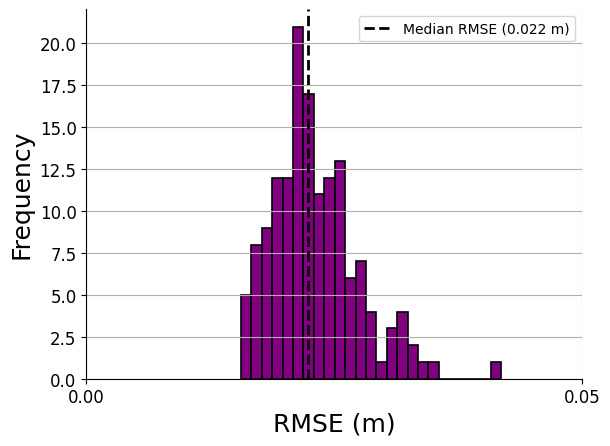

In [10]:
# FIGURE 1: Bar plot of scaling errors
create_rms_histogram(scaling_errors, save_name='scaling_errors')

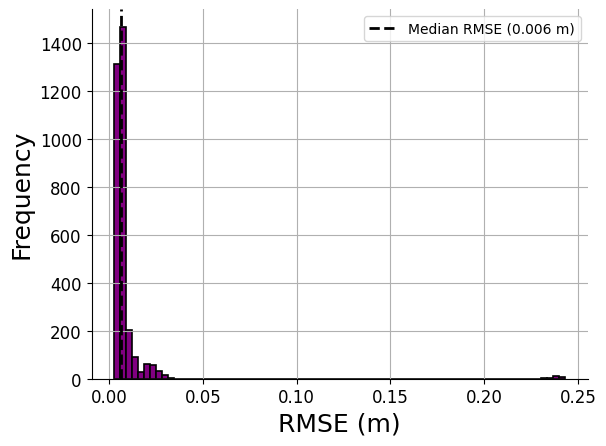

In [43]:
# FIGURE 2: Bar plot of IK errors
create_rms_histogram(ik_errors_df, save_name='ik_errors', num_bins=75)

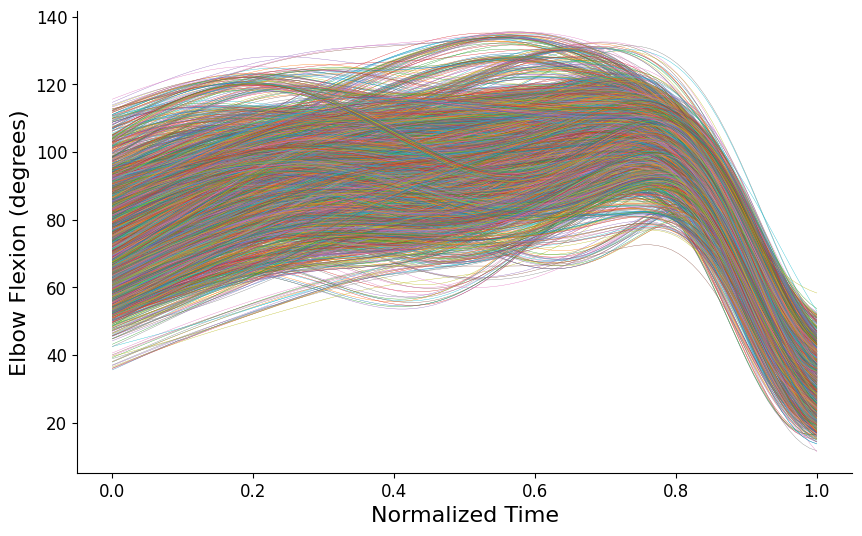

In [ ]:
# FIGURE 3: Spaghetti plot: IK joint angles (filtered to model dev data)
model_dev_data = aws_connection.load_s3_object('biomechanics/ml/modeling_datasets/model_dev_raw.csv')
ik_joint_angles_clean = ik_joint_angles_df.merge(model_dev_data['study_id'], on='study_id', how='inner')
plot_all_trajectories(ik_joint_angles_clean[ik_joint_angles_clean['subject_id'] != '2676'], 'elbow_flex')       # NOTE: 2676 is noise

$\textbf{Tables}$

In [ ]:
# load subject info & model dev data
subject_info = aws_connection.load_subject_info()
model_dev_data = aws_connection.load_s3_object('biomechanics/ml/modeling_datasets/model_dev_raw.csv')

# merge subject info w/ model dev data to normalize peak torque
model_dev_data = model_dev_data.merge(subject_info, on='subject_id', how='inner')
model_dev_data['peak_value_normalized'] = model_dev_data['peak_value'] / (model_dev_data['height'] * model_dev_data['mass'] * 9.81)  # normalize by body weight

# convert pitch types to common labels
pitch_type_map = {
    'Fastball': 'Fastball',
    'Changeup': 'Changeup',
    'Curveball': 'Curveball',
    'Slider': 'Slider',
    'Sinker': 'Fastball',
    'Cutter': 'Other',
    'Splitter': 'Changeup',
    'FastBall': 'Fastball',
    'CurveBall': 'Curveball',
    'TwoSeamFastBall': 'Fastball',
    'TwoSeamFastball': 'Fastball',
    'Other': 'Other',
    # 'Stretch' -- not a pitch type
    # 'QuickPitch' -- not a pitch type
    # 'Hesitation' -- not a pitch type
    # 'Hitch' -- not a pitch type
    '2020FB': 'Fastball',
}
model_dev_data['pitch_type'] = model_dev_data['pitch_type'].map(pitch_type_map)

# get pitch type counts
pitch_type_counts = (model_dev_data['pitch_type'].value_counts() / model_dev_data['pitch_type'].count() * 100).reset_index()

# convert release speed from mph to m/s
model_dev_data['rel_speed'] = model_dev_data['rel_speed'] * 0.44704  # convert from mph to m/s